# QAE

In [1]:
# Essential libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.result import marginal_distribution
from qiskit.transpiler import generate_preset_pass_manager
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
import pandas as pd
import math
import time

from collections import Counter

# step 1

in order to build $A$ part <br>
$A$ is the oracle for calculating the Integration <br>

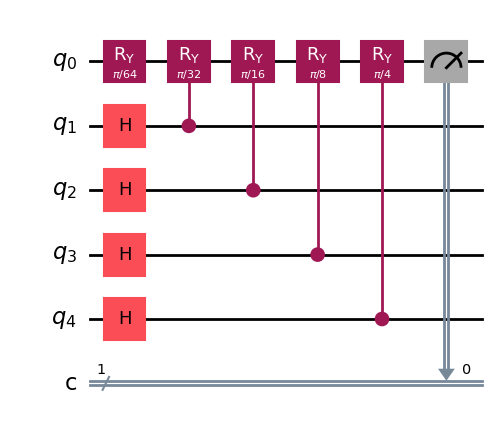

In [2]:
# build circuit
qr = QuantumRegister(5, name='q')
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr, cr)

qc.h(range(1, 5))

# set angles
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i, 0)
# measure
qc.measure(0, 0)

# show
qc.draw('mpl')


# step 2--build function

Then, we build the Grover's operator $Q$ <br>
$Q = -A S_0 A^{-1} S_f$ <br>
$Q$ amplifies the phase $\theta$ related to $\alpha$ <br>
$\alpha = sin^2(\theta)$

(each $Q$ adds $+2\theta$ in the span) <br>

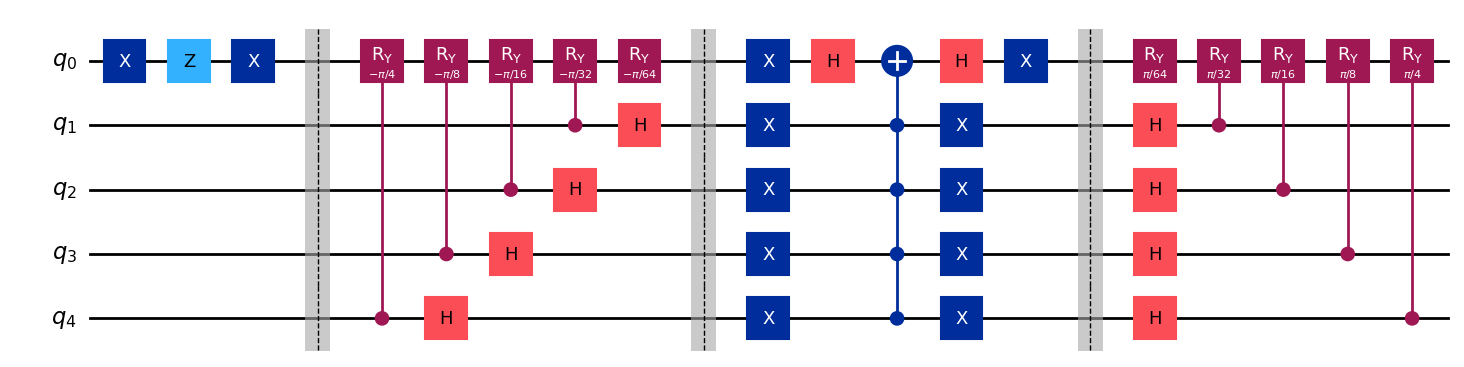

In [3]:
# build circuit
qr = QuantumRegister(5, name='q')
qc = QuantumCircuit(qr)

# S_phi_0
qc.x(0)
qc.z(0)
qc.x(0)
# barrier
qc.barrier()

# A^dagger
qc.cry(-np.pi/4, 4,0)
qc.cry(-np.pi/8, 3,0)
qc.cry(-np.pi/16, 2,0)
qc.cry(-np.pi/32, 1,0)
qc.ry(-np.pi/64, 0)
qc.h(range(1, 5))
# barrier
qc.barrier()

# S_0
qc.x(range(5))
qc.h(0)
qc.mcx([1, 2, 3, 4], 0)
qc.h(0)
qc.x(range(5))

# barrier
qc.barrier()

# A
qc.h(range(1, 5))
qc.ry(np.pi/64, 0)
qc.cry(np.pi/32, 1,0)
qc.cry(np.pi/16, 2,0)
qc.cry(np.pi/8, 3,0)
qc.cry(np.pi/4, 4,0)

# show
qc.draw('mpl')

change the operator into function to call easily

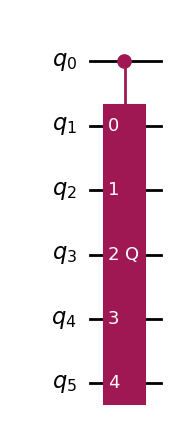

In [4]:
# set to funtion
def custom_block_gate():
    block_qc = QuantumCircuit(5, name="Q")

    # S_phi_0
    block_qc.x(0)
    block_qc.z(0)
    block_qc.x(0)

    # A^dagger
    block_qc.cry(-np.pi/4, 4, 0)
    block_qc.cry(-np.pi/8, 3, 0)
    block_qc.cry(-np.pi/16, 2, 0)
    block_qc.cry(-np.pi/32, 1, 0)
    block_qc.ry(-np.pi/64, 0)
    block_qc.h(range(1, 5))

    # S_0
    block_qc.x(range(5))
    block_qc.h(0)
    block_qc.mcx([1, 2, 3, 4], 0)
    block_qc.h(0)
    block_qc.x(range(5))

    # A
    block_qc.h(range(1, 5))
    block_qc.ry(np.pi/64, 0)
    block_qc.cry(np.pi/32, 1, 0)
    block_qc.cry(np.pi/16, 2, 0)
    block_qc.cry(np.pi/8, 3, 0)
    block_qc.cry(np.pi/4, 4, 0)

    # change to gate
    return block_qc.to_gate()

# example
qc = QuantumCircuit(6)
block_gate = custom_block_gate()
controlled_block = block_gate.control(1)
qc.append(controlled_block, [0, 1, 2, 3, 4, 5])

# show
qc.draw('mpl')


# QAE algorithm

## 3 qubit

/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3645743939.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=3, do_swaps=True).inverse()


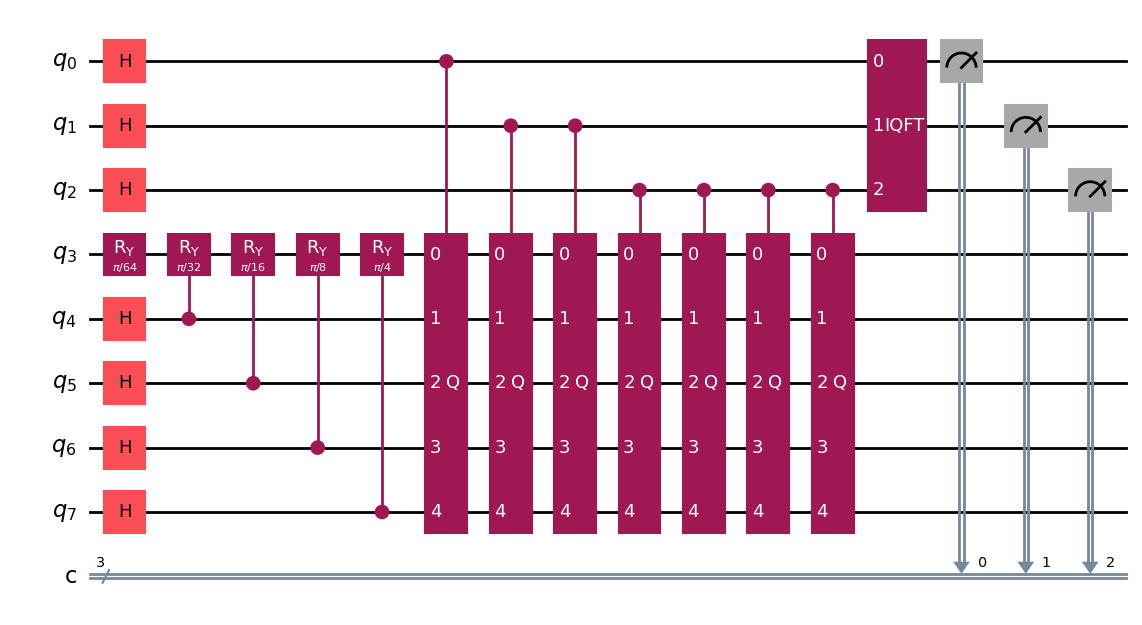

In [5]:
# build circuit
qr = QuantumRegister(8, name='q')
cr = ClassicalRegister(3, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(3))
qc.h([i + 3 for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + 3)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + 3, 0 + 3)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = [
    [0, 3, 4, 5, 6, 7],
    [1, 3, 4, 5, 6, 7],
    [1, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
]
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)

# QFT^dagger
qft_dagger = QFT(num_qubits=3, do_swaps=True).inverse()
qc.append(qft_dagger, [0, 1, 2])

# measure
qc.measure([0, 1, 2], [0, 1, 2])

# show
qc.draw('mpl')


### simulator

The frequencies are: {'001': 0.4706, '000': 0.0156, '111': 0.4912, '110': 0.0086, '010': 0.007, '100': 0.0022, '011': 0.0012, '101': 0.0036}
Sum of frequencies: 1.0


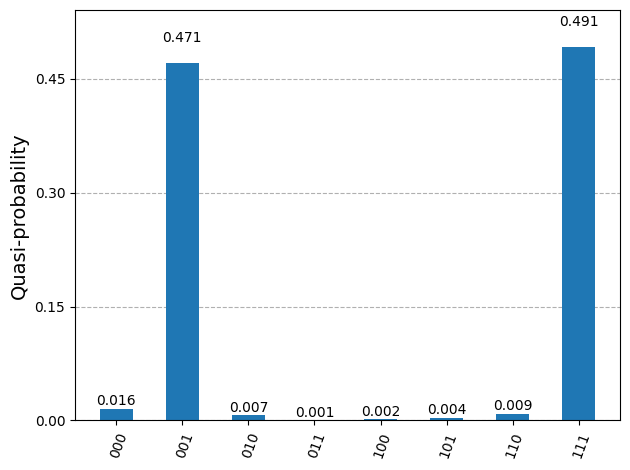

In [6]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)



mathemetic lines : <br>

$\int^1_0 sin^2(\frac{\pi}{4}x)dx = sin^2 (\frac{1 \cdot \pi}{2^3}) = 0.14645$ <br>

$\int^1_0 cos(\frac{\pi}{2}x)dx = 1 - 2 \int^1_0 sin^2(\frac{\pi}{4}x)dx = 0.63662$ <br>

## 4 qubit

/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3246481394.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()


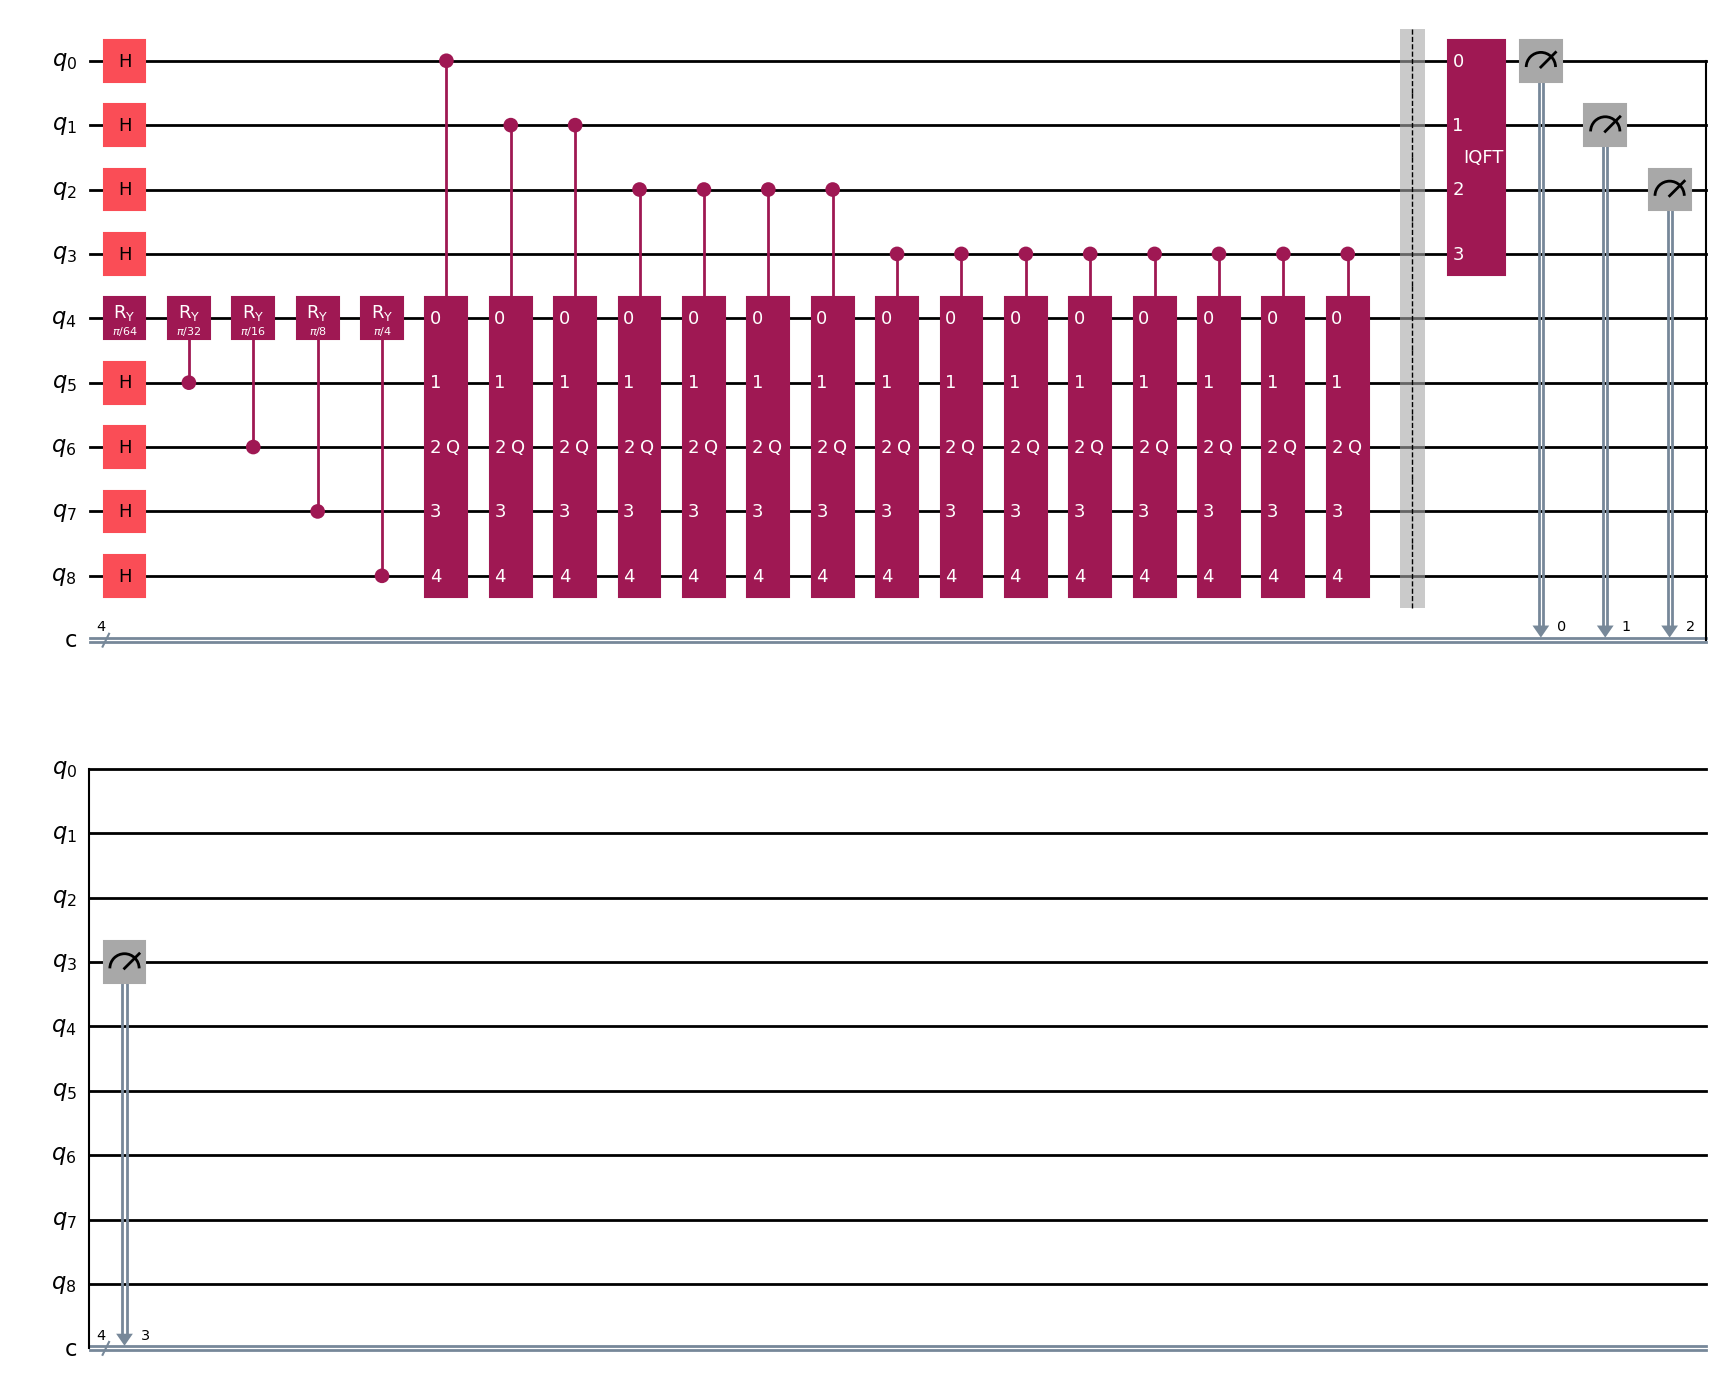

In [16]:
# set qubit we want to know
qqq = 4

# build circuit
qr = QuantumRegister(qqq+5, name='q')
cr = ClassicalRegister(qqq, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(qqq))
qc.h([i + qqq for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + qqq)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + qqq, 0 + qqq)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = []
for control in range(0, qqq):
    repeat_times = 2 ** control
    for _ in range(repeat_times):
        controlled_indices.append([control] + list(range(qqq, qqq +5)))
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)
qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
qc.append(qft_dagger, list(range(0, qqq)))

# measure
qc.measure(range(qqq), range(qqq))


qc.draw('mpl')



### simulator

The frequencies are: {'1110': 0.407, '0010': 0.4194, '1101': 0.0418, '0001': 0.018, '0110': 0.0022, '0100': 0.01, '1111': 0.0202, '0011': 0.044, '0000': 0.0092, '1100': 0.01, '1001': 0.0024, '1010': 0.0032, '1011': 0.0044, '1000': 0.0028, '0101': 0.0036, '0111': 0.0018}
Sum of frequencies: 1.0


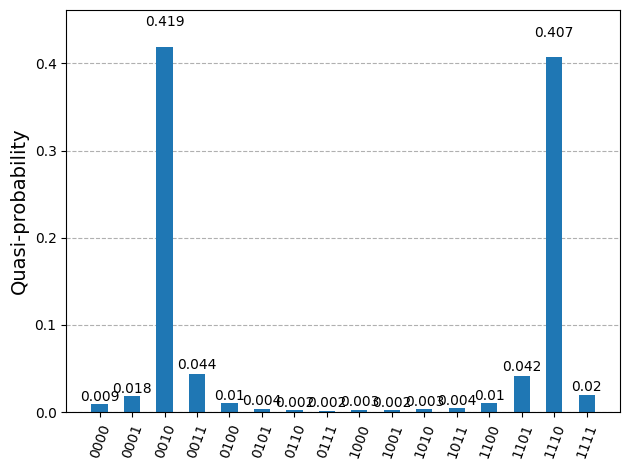

In [14]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)


mathemetic lines : <br>

$\int^1_0 sin^2(\frac{\pi}{4}x)dx = sin^2 (\frac{2 \cdot \pi}{2^4}) = 0.14645$ <br>

$\int^1_0 cos(\frac{\pi}{2}x)dx = 1 - 2 \int^1_0 sin^2(\frac{\pi}{4}x)dx = 0.63662$ <br>

## 5 qubit
we cahnge into functions to easily build circuit

/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/792500311.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()


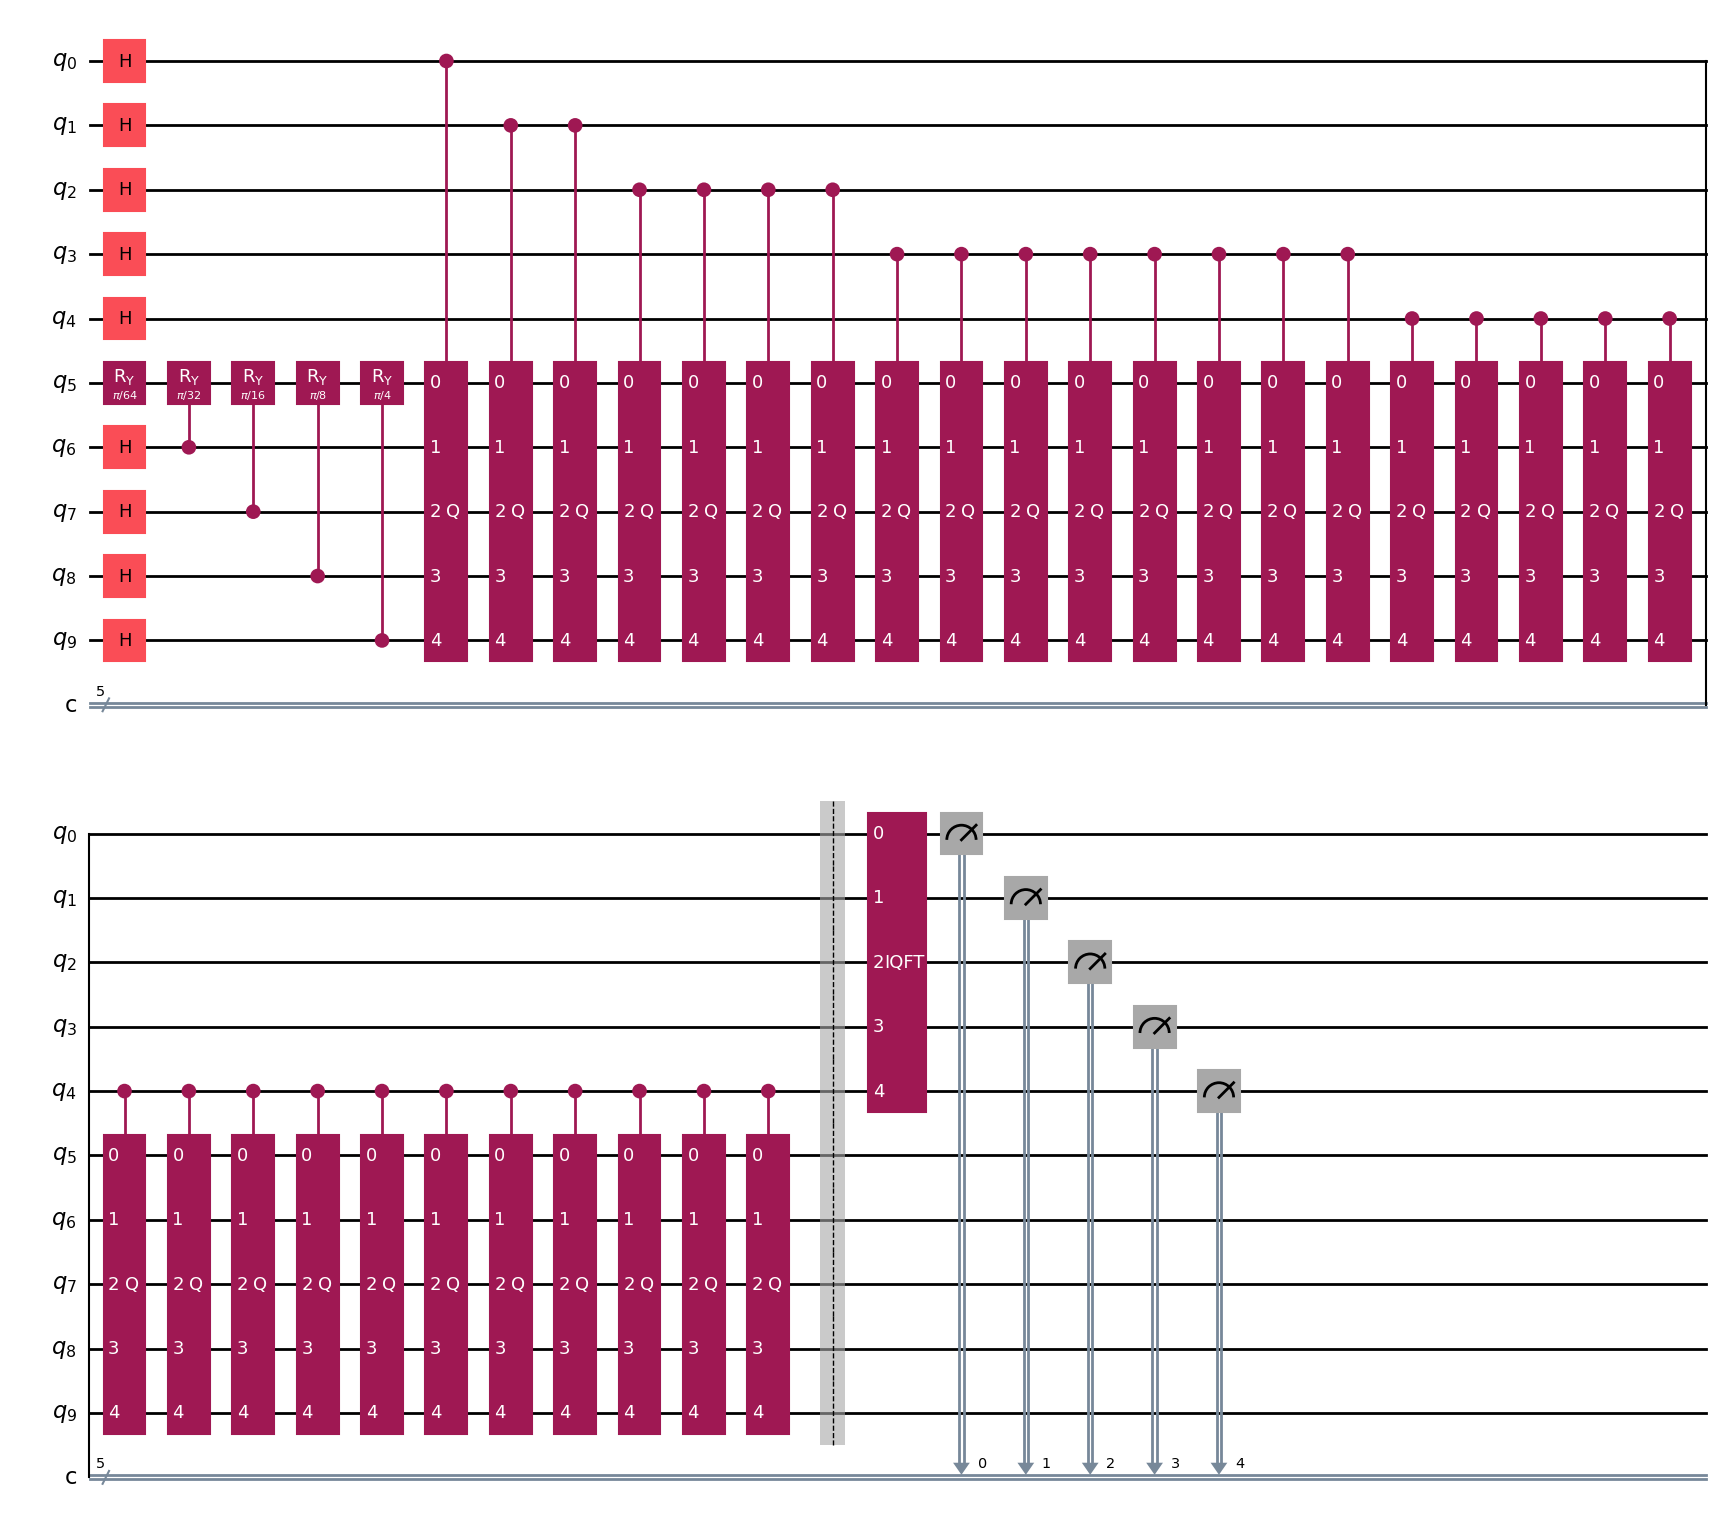

In [10]:
# set qubit we want to know
qqq = 5

# build circuit
qr = QuantumRegister(qqq+5, name='q')
cr = ClassicalRegister(qqq, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(qqq))
qc.h([i + qqq for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + qqq)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + qqq, 0 + qqq)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = []
for control in range(0, qqq):
    repeat_times = 2 ** control
    for _ in range(repeat_times):
        controlled_indices.append([control] + list(range(qqq, qqq +5)))
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)
qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
qc.append(qft_dagger, list(range(0, qqq)))

# measure
qc.measure(range(qqq), range(qqq))

# show
qc.draw('mpl')


### simulate

The frequencies are: {'11011': 0.1848, '11100': 0.2112, '00011': 0.0214, '00101': 0.195, '00100': 0.2224, '00010': 0.0086, '01000': 0.0062, '11101': 0.0238, '00001': 0.0054, '11010': 0.0218, '11001': 0.0104, '11000': 0.005, '11110': 0.0124, '10011': 0.0018, '10101': 0.0018, '11111': 0.0062, '00110': 0.0224, '10111': 0.002, '10100': 0.0014, '00111': 0.0106, '00000': 0.0068, '01111': 0.0022, '10010': 0.0018, '10001': 0.001, '01001': 0.0022, '10110': 0.0022, '01110': 0.0014, '01101': 0.0016, '01100': 0.0014, '10000': 0.001, '01010': 0.0018, '01011': 0.002}
Sum of frequencies: 1.0


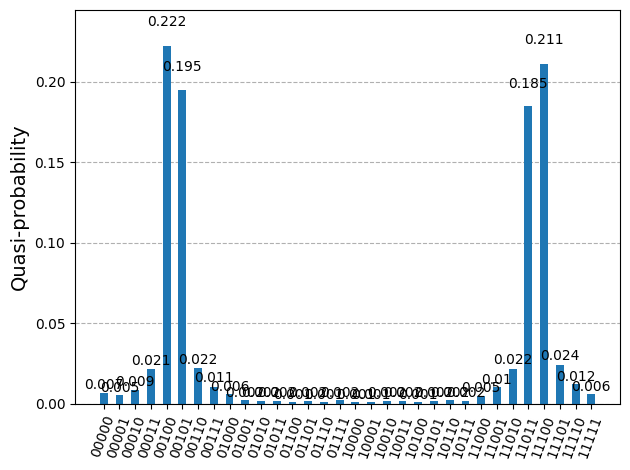

In [11]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)



## 6 qubit with simulate

/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3679763078.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()


The frequencies are: {'110111': 0.4978, '001001': 0.497, '111000': 0.0014, '110011': 0.0002, '110110': 0.001, '001000': 0.0006, '110001': 0.0002, '000011': 0.0002, '000111': 0.0008, '001011': 0.0002, '001010': 0.0002, '001100': 0.0002, '110100': 0.0002}
Sum of frequencies: 1.0


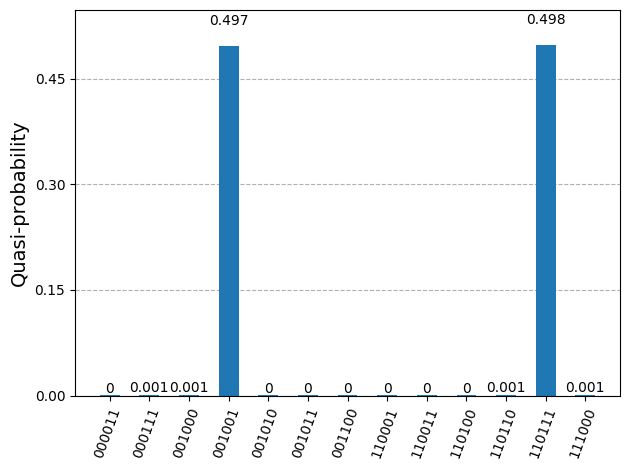

In [12]:
# set qubit we want to know
qqq = 6

# build circuit
qr = QuantumRegister(qqq+5, name='q')
cr = ClassicalRegister(qqq, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(qqq))
qc.h([i + qqq for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + qqq)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + qqq, 0 + qqq)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = []
for control in range(0, qqq):
    repeat_times = 2 ** control
    for _ in range(repeat_times):
        controlled_indices.append([control] + list(range(qqq, qqq +5)))
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)
qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
qc.append(qft_dagger, list(range(0, qqq)))

# measure
qc.measure(range(qqq), range(qqq))

# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)




mathemetic lines : <br>

$\int^1_0 sin^2(\frac{\pi}{4}x)dx = sin^2 (\frac{9 \cdot \pi}{2^6}) = 0.183247$ <br>

$\int^1_0 cos(\frac{\pi}{2}x)dx = 1 - 2 \int^1_0 sin^2(\frac{\pi}{4}x)dx = 0.6335$ <br>

## caculate |1> state

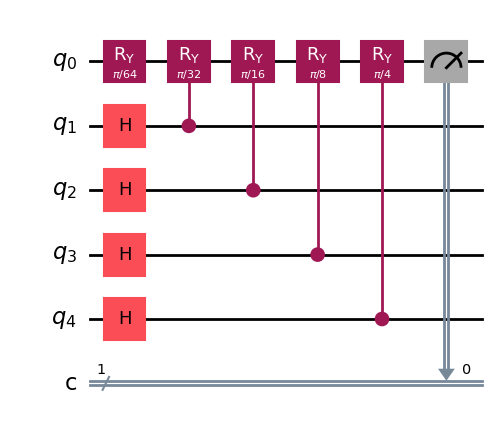

In [17]:
# build circuit
qr = QuantumRegister(5, name='q')
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr, cr)

qc.h(range(1, 5))

# set angles
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i, 0)
# measure
qc.measure(0, 0)

# show
qc.draw('mpl')


### simulator

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=100000, num_bits=1>)), metadata={'shots': 100000, 'circuit_metadata': {}})], metadata={'version': 2})
The frequencies are: {'0': 0.81678, '1': 0.18322}
Sum of frequencies: 1.0


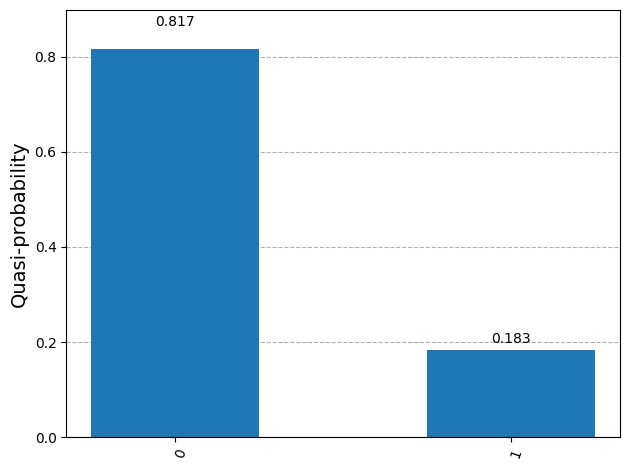

In [18]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 100000)]).result()

# access result for pub 0
data_pub = result[0].data
print(result)
# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)



# build function to caculate error(MLE)

$I = sin^2(\theta)$ <br>
$\epsilon_I \approx 2 \sqrt{I} \cdot \sqrt{1-I} \epsilon_{\theta} =$
$2 \sqrt{I(1-I)} \cdot \frac{\pi}{2^n} \propto \frac{1}{N}$

In [19]:
# we already find freq
freq = frequencies

def caculate_I(freq, qqq):
    I = sum(
    freq[k] * np.sin(int(k, 2) * np.pi / 2**(qqq)) ** 2
    for k in freq)
    return I


I = caculate_I(freq, qqq)
print(I)


0.006973396026641019


In [20]:
def caculate_epsi_I(I, qqq):
    epsi_I = np.pi * np.sqrt(I * (1 - I)) / (2 ** (qqq - 1))
    return epsi_I

epsi_I = caculate_epsi_I(I, qqq)
print(epsi_I)

0.032678528525933


## try 7 qubit and caculate

In [21]:
# set qubit we want to know
qqq = 7

# build circuit
qr = QuantumRegister(qqq+5, name='q')
cr = ClassicalRegister(qqq, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(qqq))
qc.h([i + qqq for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + qqq)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + qqq, 0 + qqq)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = []
for control in range(0, qqq):
    repeat_times = 2 ** control
    for _ in range(repeat_times):
        controlled_indices.append([control] + list(range(qqq, qqq +5)))
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)
qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
qc.append(qft_dagger, list(range(0, qqq)))

# measure
qc.measure(range(qqq), range(qqq))

# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)

freq = frequencies
I = caculate_I(freq, qqq)
print("I :", I)
epsi_I = caculate_epsi_I(I, qqq)
print("epsi_I :", epsi_I)



/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3289991464.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()


The frequencies are: {'1101110': 0.4854, '0010010': 0.5016, '1110011': 0.0002, '0000101': 0.0002, '0001100': 0.0004, '0010011': 0.0016, '1101111': 0.0028, '0010001': 0.0028, '0010000': 0.0004, '1101101': 0.0022, '0001111': 0.0004, '1100110': 0.0002, '1101100': 0.0002, '0010100': 0.0002, '0011101': 0.0002, '1100101': 0.0002, '0011001': 0.0002, '1110000': 0.0002, '1110001': 0.0002, '0101011': 0.0002, '0001101': 0.0002}
Sum of frequencies: 1.0
I : 0.18289497229640994
epsi_I : 0.018976220739936572


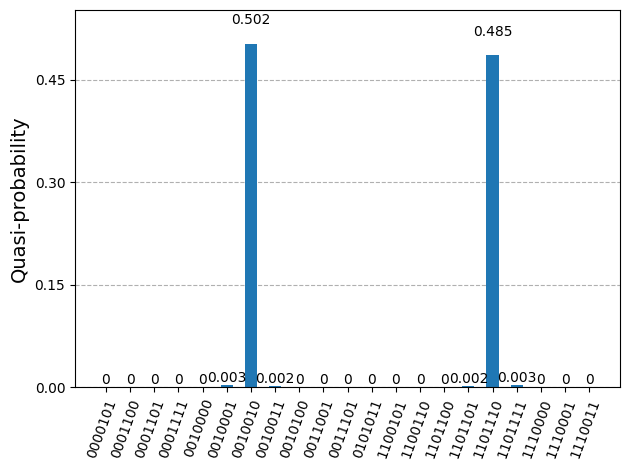

In [ ]:
plot_histogram(frequencies)

# qqq = 3~15

In [23]:
results_list = []

for qqq in range(3, 12):  # qqq = 3 ~ 11
    # build qc
    qr = QuantumRegister(qqq + 5, name='q')
    cr = ClassicalRegister(qqq, name='c')
    qc = QuantumCircuit(qr, cr)

    # init
    qc.h(range(qqq))
    qc.h([i + qqq for i in range(1, 5)])

    # ry + cry
    angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
    qc.ry(angles[0], 0 + qqq)
    for i, angle in enumerate(angles[1:], start=1):
        qc.cry(angle, i + qqq, 0 + qqq)

    # multiple control gate
    block_gate = custom_block_gate()
    controlled_indices = []
    for control in range(0, qqq):
        repeat_times = 2 ** control
        for _ in range(repeat_times):
            controlled_indices.append([control] + list(range(qqq, qqq + 5)))
    for indices in controlled_indices:
        qc.append(block_gate.control(1), indices)
    qc.barrier()

    # QFT^dagger
    qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
    qc.append(qft_dagger, list(range(0, qqq)))

    # measure
    qc.measure(range(qqq), range(qqq))

    # simulate
    sampler = StatevectorSampler()
    result = sampler.run([(qc, None, 100)]).result()
    data_pub = result[0].data
    counts = data_pub.c.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # caculate I & epsilon_I
    I = caculate_I(frequencies, qqq)
    epsi_I = caculate_epsi_I(I, qqq)

    # save to list
    results_list.append({
        "qqq": qqq,
        "I": I,
        "epsi_I": epsi_I
    })

# cahnge to df
df = pd.DataFrame(results_list)
df


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/2791453660.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/2791453660.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/2791453660.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated

,qqq,I,epsi_I
0,3,0.159731,0.287736
1,4,0.155671,0.142370
2,5,0.207210,0.079582
3,6,0.183197,0.037977
4,7,0.182618,0.018965
5,8,0.182949,0.009489
6,9,0.181668,0.004732
7,10,0.181696,0.002366
8,11,0.181619,0.001183


# result

In [24]:
df = df.rename(columns={"qqq": "qpe_qubit", "I": "estimate_result"})
df

,qpe_qubit,estimate_result,epsi_I
0,3,0.159731,0.287736
1,4,0.155671,0.142370
2,5,0.207210,0.079582
3,6,0.183197,0.037977
4,7,0.182618,0.018965
5,8,0.182949,0.009489
6,9,0.181668,0.004732
7,10,0.181696,0.002366
8,11,0.181619,0.001183


### estimate v.s. qubits

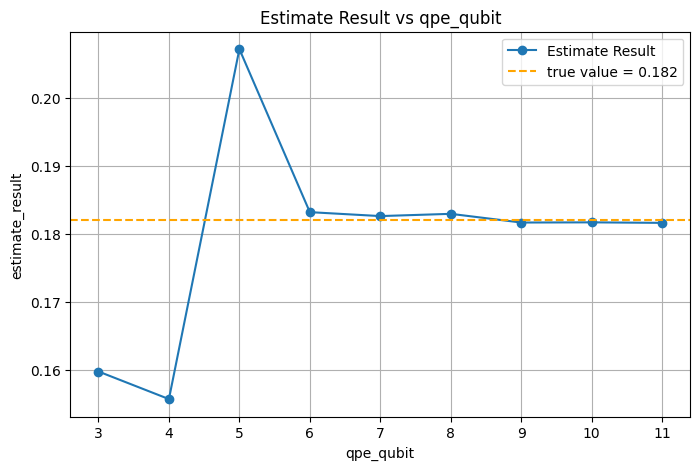

In [ ]:
# make df
df = df.rename(columns={"qqq": "qpe_qubit", "I": "estimate_result"})

# plot
plt.figure(figsize=(8, 5))
plt.plot(df["qpe_qubit"], df["estimate_result"], marker="o", label="Estimate Result")
plt.axhline(y=0.182, color="orange", linestyle="--", label="true value = 0.182")
plt.xlabel("qpe_qubit")
plt.ylabel("estimate_result")
plt.title("Estimate Result vs qpe_qubit")
plt.grid(True)
plt.legend()
plt.show()



### error v.s. qubits

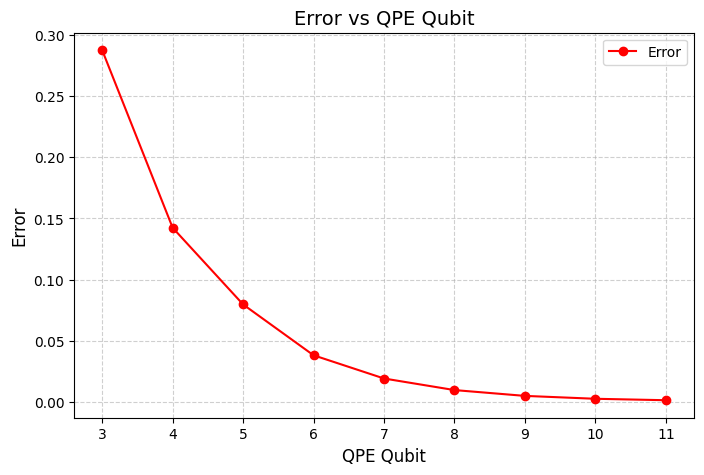

In [ ]:
# make df
df_plot2 = df.rename(columns={"qqq": "qpe_qubit", "epsi_I": "error"})

# plot
plt.figure(figsize=(8, 5))
plt.plot(df_plot2["qpe_qubit"], df_plot2["error"], marker='o', color='red', label='Error')
plt.xlabel("QPE Qubit", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.title("Error vs QPE Qubit", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


### error v.s. qubit

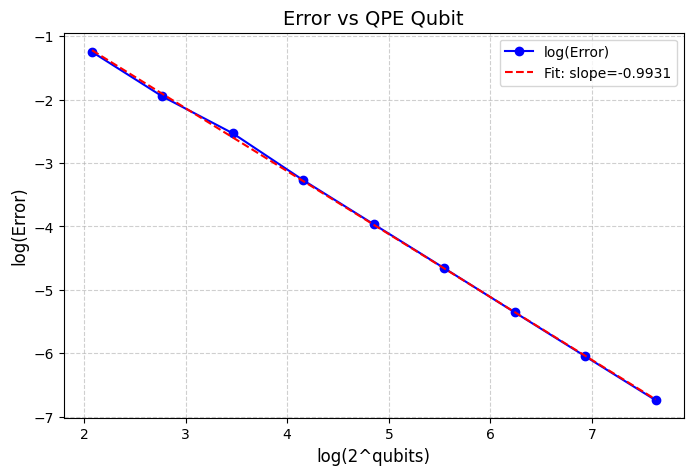

In [ ]:
# make df
df_plot2 = df.rename(columns={"qqq": "qpe_qubit", "epsi_I": "error"})

# add log value
df3 = df_plot2.copy()
df3["log_error"] = np.log(df3["error"])
df3["log_2_qubits"] = np.log(2 ** df3["qpe_qubit"])

# caculate slope
slope, intercept = np.polyfit(df3["log_2_qubits"], df3["log_error"], 1)

# plot
plt.figure(figsize=(8, 5))
plt.plot(df3["log_2_qubits"], df3["log_error"], marker='o', color='blue', label='log(Error)')
plt.plot(df3["log_2_qubits"], slope * df3["log_2_qubits"] + intercept, linestyle='--', color='red',
         label=f'Fit: slope={slope:.4f}')
plt.xlabel("log(2^qubits)", fontsize=12)
plt.ylabel("log(Error)", fontsize=12)
plt.title("Error vs QPE Qubit", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## classical shot

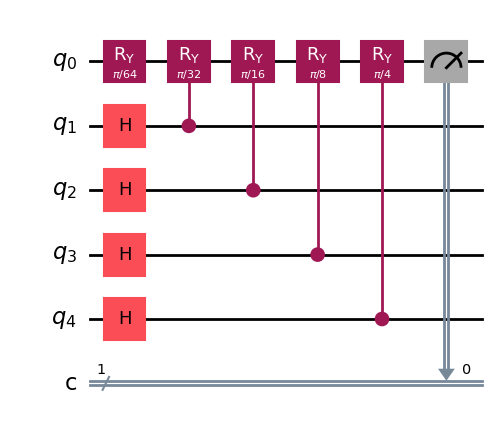

In [28]:
# build circuit
qr = QuantumRegister(5, name='q')
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr, cr)

qc.h(range(1, 5))

# set angles
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i, 0)
# measure
qc.measure(0, 0)

# show
qc.draw('mpl')


The frequencies are: {'0': 0.8179, '1': 0.1821}
Sum of frequencies: 1.0


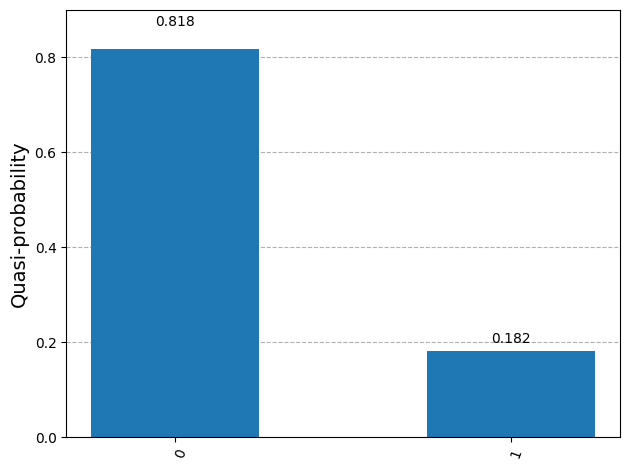

In [29]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 100000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)




In [30]:
c_shot_list = []
for i in range(3,12):
    c_shot = 2**(i+1) -1
    c_shot_list.append(c_shot)
print(c_shot_list)

[15, 31, 63, 127, 255, 511, 1023, 2047, 4095]


In [ ]:
results_list = []
for c_shot in c_shot_list:
    # run on statevectorsampler
    sampler = StatevectorSampler()
    # set shot=5000
    result = sampler.run([(qc, None, c_shot)]).result()

    # access result for pub 0
    data_pub = result[0].data

    # get counts for classical
    counts = data_pub.c.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # save to list
    results_list.append({
        "c_shot": c_shot,
        "freq": frequencies,
    })

results_list


[{'c_shot': 15, 'freq': {'0': 0.8666666666666667, '1': 0.13333333333333333}},
 {'c_shot': 31, 'freq': {'0': 0.8064516129032258, '1': 0.1935483870967742}},
 {'c_shot': 63, 'freq': {'0': 0.7777777777777778, '1': 0.2222222222222222}},
 {'c_shot': 127, 'freq': {'0': 0.7716535433070866, '1': 0.2283464566929134}},
 {'c_shot': 255, 'freq': {'0': 0.8392156862745098, '1': 0.1607843137254902}},
 {'c_shot': 511, 'freq': {'1': 0.19569471624266144, '0': 0.8043052837573386}},
 {'c_shot': 1023, 'freq': {'0': 0.8074291300097751, '1': 0.19257086999022482}},
 {'c_shot': 2047, 'freq': {'0': 0.8216902784562775, '1': 0.17830972154372252}},
 {'c_shot': 4095, 'freq': {'0': 0.821001221001221, '1': 0.178998778998779}}]

real value = $\sum^{(2^4-1)}_{i=0}sin^2(\frac{\pi}{64}i+\frac{\pi}{128})*\frac{1}{16}$

In [32]:
i = np.arange(16)
real_value = np.sum(np.sin(np.pi/64 * i + np.pi/128)**2 * (1/16))


$\sqrt{\frac{1}{M} \sum^M_{i=1}(realvalue - a_i)^2}$

In [ ]:
classical_df = pd.DataFrame([
    {"c_shot": item["c_shot"], "I": item["freq"].get("1", 0)}
    for item in results_list
])

# caculate epsi_I
classical_df["epsi_I"] = np.pi * np.sqrt(classical_df["I"] * (1 - classical_df["I"])) / classical_df["c_shot"]

classical_df


,c_shot,I,epsi_I
0,15,0.133333,0.071196
1,31,0.193548,0.040038
2,63,0.222222,0.020732
3,127,0.228346,0.010384
4,255,0.160784,0.004526
5,511,0.195695,0.002439
6,1023,0.192571,0.001211
7,2047,0.178310,0.000587
8,4095,0.178999,0.000294


In [34]:
M = 100

# caculate real_value
i = np.arange(16)
real_value = np.sum(np.sin(np.pi/64 * i + np.pi/128)**2 * (1/16))

results_list = []

for c_shot in c_shot_list:
    I_list = []
    
    for _ in range(M):
        # run on statevectorsampler
        sampler = StatevectorSampler()
        result = sampler.run([(qc, None, c_shot)]).result()

        # access result for pub 0
        data_pub = result[0].data

        # get counts for classical
        counts = data_pub.c.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}

        # freq for "1"
        I_list.append(frequencies.get('1', 0))
    
    # caculate rmse
    error = np.sqrt(np.mean([(real_value - I_i)**2 for I_i in I_list]))
    
    # to list
    results_list.append({
        "c_shot": c_shot,
        "error": error
    })

# to df
error_df = pd.DataFrame(results_list)
error_df


,c_shot,error
0,15,0.088254
1,31,0.069787
2,63,0.043057
3,127,0.029467
4,255,0.023158
5,511,0.015300
6,1023,0.012750
7,2047,0.009503
8,4095,0.005840


## error v.s. classical shot (log)

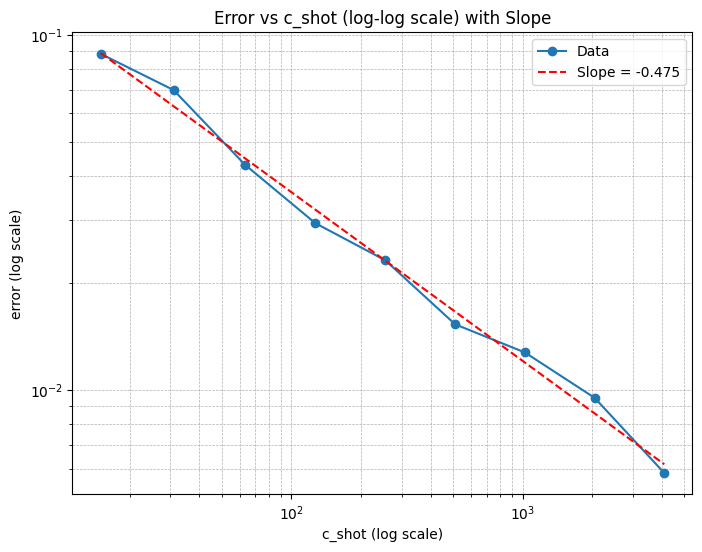

In [35]:
# caculate log slope
log_x = np.log(error_df["c_shot"])
log_y = np.log(error_df["error"])
slope, intercept = np.polyfit(log_x, log_y, 1)

# plot
plt.figure(figsize=(8, 6))
plt.plot(error_df["c_shot"], error_df["error"], marker='o', linestyle='-', label="Data")
plt.xscale("log")
plt.yscale("log")

# add slope
fit_y = np.exp(intercept) * error_df["c_shot"]**slope
plt.plot(error_df["c_shot"], fit_y, linestyle="--", color="red", label=f"Slope = {slope:.3f}")

plt.xlabel("c_shot (log scale)")
plt.ylabel("error (log scale)")
plt.title("Error vs c_shot (log-log scale) with Slope")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()




# combine together

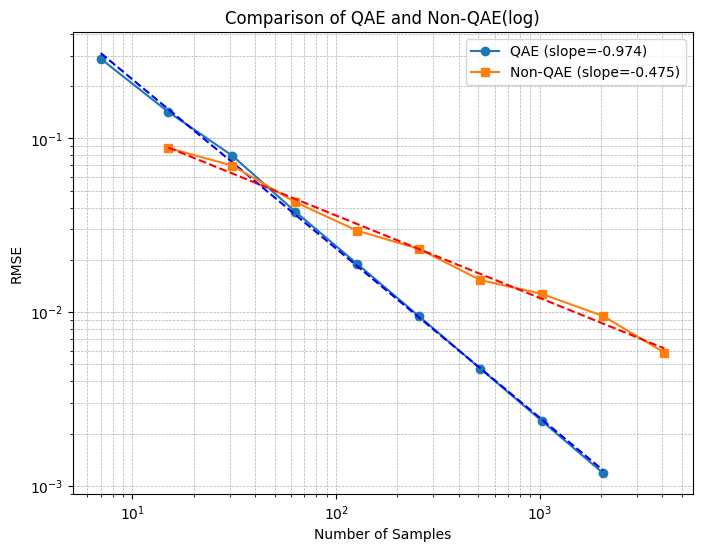

In [36]:
# with qae
df_plot2 = df.rename(columns={"qqq": "qpe_qubit", "epsi_I": "error"})

# non-qae
df3 = df_plot2.copy()
df3["c_shot"] = 2 ** df3["qpe_qubit"] - 1

# get regression line with qae (log-log)
log_x1 = np.log(df3["c_shot"])
log_y1 = np.log(df3["error"])
slope1, intercept1 = np.polyfit(log_x1, log_y1, 1)
fit_y1 = np.exp(intercept1) * df3["c_shot"]**slope1

# get regression line with non-qae (log-log)
log_x2 = np.log(error_df["c_shot"])
log_y2 = np.log(error_df["error"])
slope2, intercept2 = np.polyfit(log_x2, log_y2, 1)
fit_y2 = np.exp(intercept2) * error_df["c_shot"]**slope2

# plot
plt.figure(figsize=(8, 6))
## qae
plt.plot(df3["c_shot"], df3["error"], marker='o', linestyle='-', label=f"QAE (slope={slope1:.3f})")
plt.plot(df3["c_shot"], fit_y1, linestyle="--", color="blue")
## non-qae
plt.plot(error_df["c_shot"], error_df["error"], marker='s', linestyle='-', label=f"Non-QAE (slope={slope2:.3f})")
plt.plot(error_df["c_shot"], fit_y2, linestyle="--", color="red")
# set log-log
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples")
plt.ylabel("RMSE")
plt.title("Comparison of QAE and Non-QAE(log)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


# new function -- advance
function : $cos(\theta) = 1 - 2sin^2(\frac{\theta}{2})$ <br>
set $P = 0.6$ <br>

In [37]:
P = 0.8
phi = 2 * np.arccos(np.sqrt(P))
print(phi)


0.9272952180016123


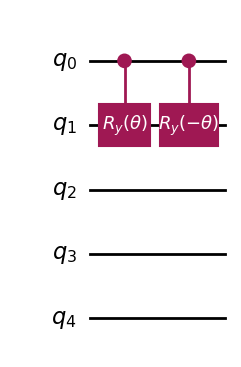

In [38]:
# set to funtion
def control_pos_ry_gate(theta):
    block_qc = QuantumCircuit(1, name=r"$R_y(\theta)$")
    block_qc.ry(theta, 0)

    # change to gate
    return block_qc.to_gate()

def control_neg_ry_gate(theta):
    block_qc = QuantumCircuit(1, name=r"$R_y(-\theta)$")
    block_qc.ry(-theta, 0)

    # change to gate
    return block_qc.to_gate()

# example
qc = QuantumCircuit(5)
block_gate = control_pos_ry_gate(P)
controlled_block = block_gate.control(1)
qc.append(controlled_block, [0, 1])
block_gate = control_neg_ry_gate(P)
controlled_block = block_gate.control(1)
qc.append(controlled_block, [0, 1])

# show
qc.draw('mpl')


## part A qc
$p \cdot cos(\theta) + q \cdot cos(-\theta) = A$ <br>

ref : shows in `advance.pdf` page 2 <br>

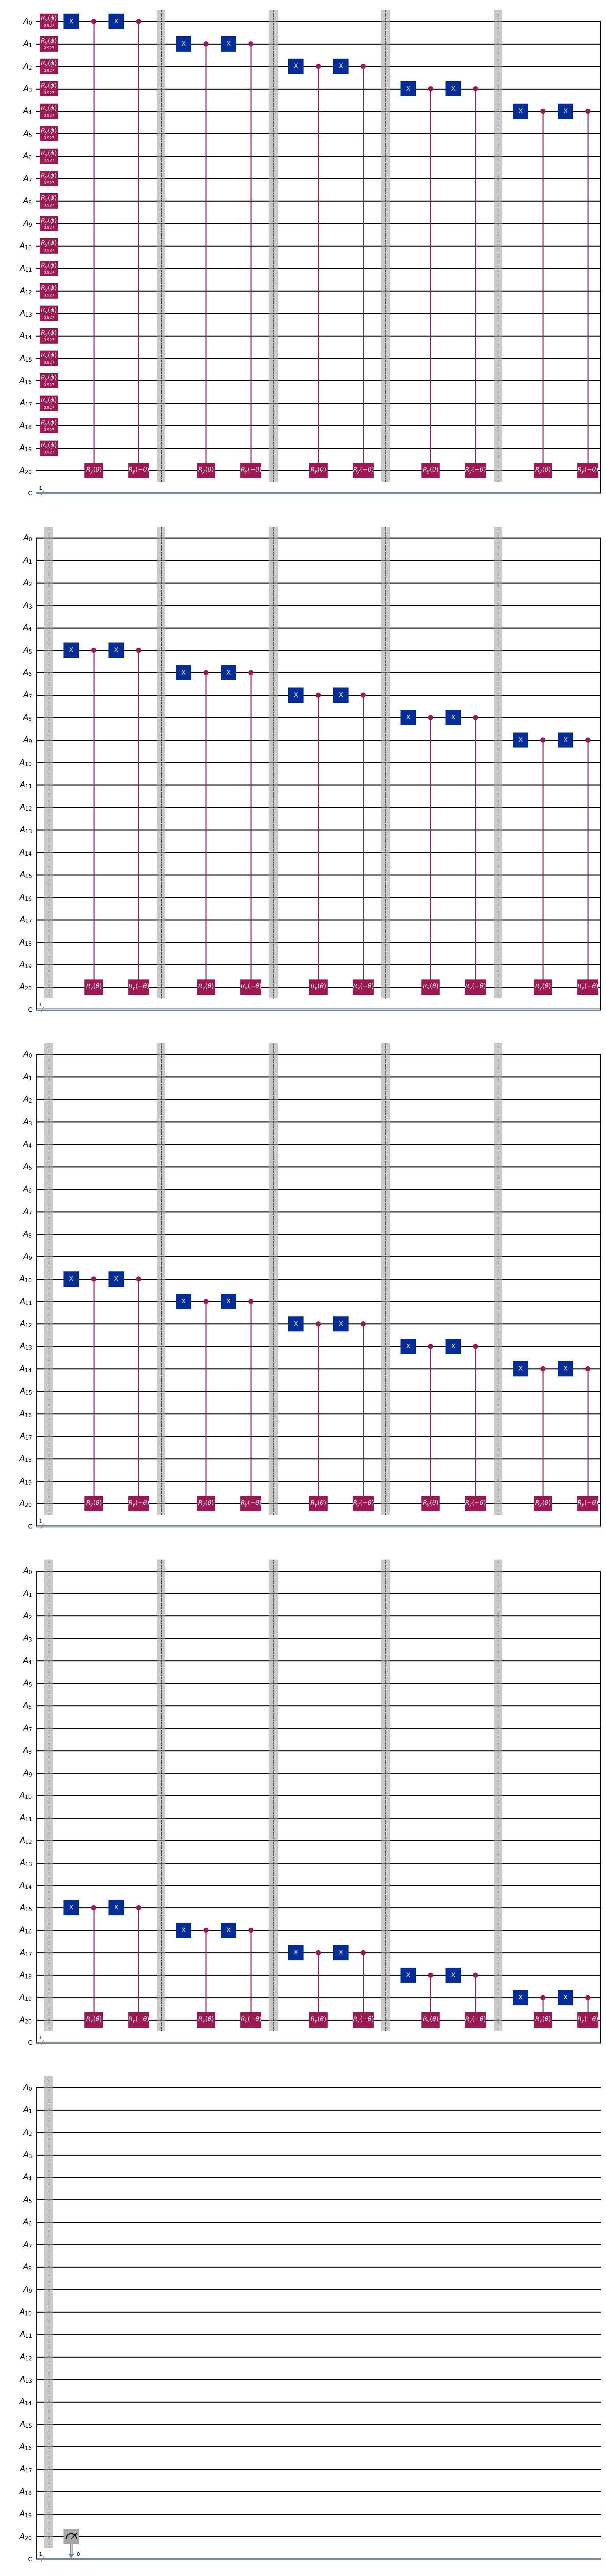

In [ ]:
theta = np.pi
step = 20
qr = QuantumRegister(step+1, name='A')
cr = ClassicalRegister(1, name='c')
qc_A = QuantumCircuit(qr,cr)

# Ry(phi) for first 4 qubits
qc_A.ry(phi, range(step), r"$R_y(\phi)$")

for ctrl_qubit in range(step):
    qc_A.x(ctrl_qubit)
    
    c_pos_gate = control_pos_ry_gate(theta).control(1)
    qc_A.append(c_pos_gate, [ctrl_qubit, step])
    
    qc_A.x(ctrl_qubit)
    
    c_neg_gate = control_neg_ry_gate(theta).control(1)
    qc_A.append(c_neg_gate, [ctrl_qubit, step])
    
    qc_A.barrier()

qc_A.measure(step, 0)

# show
qc_A.draw('mpl')


## part B qc
$p \cdot sin(\theta) + q \cdot sin(-\theta) = B$ <br>

ref : shows in `advance.pdf` page 2 <br>

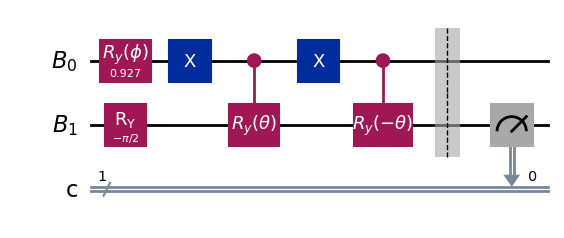

In [40]:
theta = np.pi
step = 1
qr = QuantumRegister(step+1, name='B')
cr = ClassicalRegister(1, name='c')
qc_B = QuantumCircuit(qr, cr)

# Ry(phi) for first 4 qubits
qc_B.ry(phi, range(step), r"$R_y(\phi)$")
qc_B.ry(-np.pi/2, step)

for ctrl_qubit in range(step):
    qc_B.x(ctrl_qubit)
    
    c_pos_gate = control_pos_ry_gate(theta).control(1)
    qc_B.append(c_pos_gate, [ctrl_qubit, step])
    
    qc_B.x(ctrl_qubit)
    
    c_neg_gate = control_neg_ry_gate(theta).control(1)
    qc_B.append(c_neg_gate, [ctrl_qubit, step])
    
    qc_B.barrier()

qc_B.measure(step,0)

# show
qc_B.draw('mpl')




cut into 17 slice --> 2 * 8 + 1

# sample

## part A

In [ ]:
# set theta
theta_values = np.linspace(-np.pi, np.pi, 51)

step = 20
results_list = []

for theta in theta_values:
    # build qc
    qr = QuantumRegister(step + 1, name='A')
    cr = ClassicalRegister(1, name='c_A')
    qc_A = QuantumCircuit(qr, cr)
    # Ry(phi) for first step qubits
    qc_A.ry(phi, range(step), r"$R_y(\phi)$")

    for ctrl_qubit in range(step):
        qc_A.x(ctrl_qubit)

        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_A.append(c_pos_gate, [ctrl_qubit, step])

        qc_A.x(ctrl_qubit)

        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_A.append(c_neg_gate, [ctrl_qubit, step])

        qc_A.barrier()
    qc_A.measure(step, 0)
    # run on statevectorsampler
    sampler = StatevectorSampler()
    result = sampler.run([(qc_A, None, 10000)]).result()

    # access result
    data_pub = result[0].data
    counts = data_pub.c_A.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # get '1' probability to be the observation
    I = frequencies.get('1', 0)
    results_list.append({
        "theta": theta,
        "freq_1": I
    })

# cahange to df
df_A_v_17 = pd.DataFrame(results_list)
print(df_A_v_17)


           theta  freq_1
0  -3.141593e+00  0.0000
1  -3.015929e+00  0.4843
2  -2.890265e+00  0.8318
3  -2.764602e+00  0.5113
4  -2.638938e+00  0.4036
5  -2.513274e+00  0.5093
6  -2.387610e+00  0.5154
7  -2.261947e+00  0.4999
8  -2.136283e+00  0.5047
9  -2.010619e+00  0.5020
10 -1.884956e+00  0.5015
11 -1.759292e+00  0.4962
12 -1.633628e+00  0.4913
13 -1.507964e+00  0.4982
14 -1.382301e+00  0.4965
15 -1.256637e+00  0.5108
16 -1.130973e+00  0.5031
17 -1.005310e+00  0.4967
18 -8.796459e-01  0.4970
19 -7.539822e-01  0.5086
20 -6.283185e-01  0.5127
21 -5.026548e-01  0.4011
22 -3.769911e-01  0.5049
23 -2.513274e-01  0.8397
24 -1.256637e-01  0.4787
25  4.440892e-16  0.0000
26  1.256637e-01  0.4794
27  2.513274e-01  0.8296
28  3.769911e-01  0.5116
29  5.026548e-01  0.3970
30  6.283185e-01  0.5164
31  7.539822e-01  0.5106
32  8.796459e-01  0.4948
33  1.005310e+00  0.5026
34  1.130973e+00  0.4984
35  1.256637e+00  0.4978
36  1.382301e+00  0.4998
37  1.507964e+00  0.5017
38  1.633628e+00  0.4961


## part B

           theta  freq_1
0  -3.141593e+00  0.5063
1  -3.015929e+00  0.0479
2  -2.890265e+00  0.4723
3  -2.764602e+00  0.7021
4  -2.638938e+00  0.4958
5  -2.513274e+00  0.4701
6  -2.387610e+00  0.5165
7  -2.261947e+00  0.4966
8  -2.136283e+00  0.5044
9  -2.010619e+00  0.4971
10 -1.884956e+00  0.4972
11 -1.759292e+00  0.4988
12 -1.633628e+00  0.5162
13 -1.507964e+00  0.4974
14 -1.382301e+00  0.4996
15 -1.256637e+00  0.4949
16 -1.130973e+00  0.5101
17 -1.005310e+00  0.4958
18 -8.796459e-01  0.4964
19 -7.539822e-01  0.4841
20 -6.283185e-01  0.5316
21 -5.026548e-01  0.5131
22 -3.769911e-01  0.3015
23 -2.513274e-01  0.5243
24 -1.256637e-01  0.9565
25  4.440892e-16  0.4899
26  1.256637e-01  0.0507
27  2.513274e-01  0.4768
28  3.769911e-01  0.7031
29  5.026548e-01  0.4827
30  6.283185e-01  0.4648
31  7.539822e-01  0.5087
32  8.796459e-01  0.5033
33  1.005310e+00  0.4962
34  1.130973e+00  0.4997
35  1.256637e+00  0.4981
36  1.382301e+00  0.4942
37  1.507964e+00  0.4974
38  1.633628e+00  0.5009


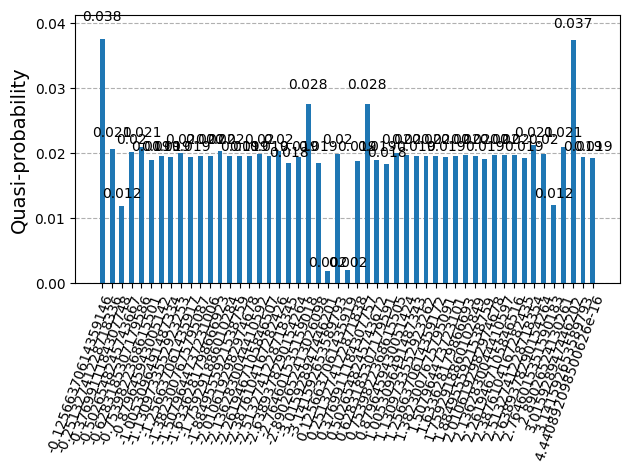

In [42]:
# set theta
theta_values = np.linspace(-np.pi, np.pi, 51)

step = 20
results_list = []

for theta in theta_values:
    # build qc
    qr = QuantumRegister(step + 1, name='B')
    cr = ClassicalRegister(1, name='c_B')
    qc_B = QuantumCircuit(qr, cr)

    # Ry(phi) for first step qubits
    qc_B.ry(phi, range(step), r"$R_y(\phi)$")
    qc_B.ry(-np.pi/2, step)

    for ctrl_qubit in range(step):
        qc_B.x(ctrl_qubit)

        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_B.append(c_pos_gate, [ctrl_qubit, step])

        qc_B.x(ctrl_qubit)

        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_B.append(c_neg_gate, [ctrl_qubit, step])

        qc_B.barrier()
    qc_B.measure(step, 0)
    # run on statevectorsampler
    sampler = StatevectorSampler()
    result = sampler.run([(qc_B, None, 10000)]).result()
    
    # access result
    data_pub = result[0].data
    counts = data_pub.c_B.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # get '1' probability to be the observation
    I = frequencies.get('1', 0)
    results_list.append({
        "theta": theta,
        "freq_1": I
    })

# cahange to df
df_B_v_17 = pd.DataFrame(results_list)
print(df_B_v_17)

plot_histogram({str(row["theta"]): row["freq_1"] for _, row in df_B_v_17.iterrows()})


# adjust df

In [43]:
df_A_v_17

,theta,freq_1
0,-3.141593e+00,0.0000
1,-3.015929e+00,0.4843
2,-2.890265e+00,0.8318
3,-2.764602e+00,0.5113
4,-2.638938e+00,0.4036
5,-2.513274e+00,0.5093
6,-2.387610e+00,0.5154
7,-2.261947e+00,0.4999
8,-2.136283e+00,0.5047
9,-2.010619e+00,0.5020


In [45]:
# A
# build adjust df
adj_df_A_v_17 = df_A_v_17.copy()
# change row name
adj_df_A_v_17["adj_freq"] = 1 - 2 * adj_df_A_v_17["freq_1"]
adj_df_A_v_17 = adj_df_A_v_17.drop(columns=["freq_1"])
display(adj_df_A_v_17)

# B
# build adjust df
adj_df_B_v_17 = df_B_v_17.copy()
# change row name
adj_df_B_v_17["adj_freq"] = 1 - 2 * adj_df_B_v_17["freq_1"]
adj_df_B_v_17 = adj_df_B_v_17.drop(columns=["freq_1"])
display(adj_df_B_v_17)



,theta,adj_freq
0,-3.141593e+00,1.0000
1,-3.015929e+00,0.0314
2,-2.890265e+00,-0.6636
3,-2.764602e+00,-0.0226
4,-2.638938e+00,0.1928
5,-2.513274e+00,-0.0186
6,-2.387610e+00,-0.0308
7,-2.261947e+00,0.0002
8,-2.136283e+00,-0.0094
9,-2.010619e+00,-0.0040


,theta,adj_freq
0,-3.141593e+00,-0.0126
1,-3.015929e+00,0.9042
2,-2.890265e+00,0.0554
3,-2.764602e+00,-0.4042
4,-2.638938e+00,0.0084
5,-2.513274e+00,0.0598
6,-2.387610e+00,-0.0330
7,-2.261947e+00,0.0068
8,-2.136283e+00,-0.0088
9,-2.010619e+00,0.0058


In [46]:
# sort by theta
df_A_sorted = adj_df_A_v_17.sort_values(by="theta").reset_index(drop=True)
df_B_sorted = adj_df_B_v_17.sort_values(by="theta").reset_index(drop=True)

# build complex value
complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]

# new df
df_complex = pd.DataFrame({
    "theta": df_A_sorted["theta"],
    "A_plus_iB": complex_values
})

display(df_complex)


,theta,A_plus_iB
0,-3.141593e+00,1.0000-0.0126j
1,-3.015929e+00,0.0314+0.9042j
2,-2.890265e+00,-0.6636+0.0554j
3,-2.764602e+00,-0.0226-0.4042j
4,-2.638938e+00,0.1928+0.0084j
5,-2.513274e+00,-0.0186+0.0598j
6,-2.387610e+00,-0.0308-0.0330j
7,-2.261947e+00,0.0002+0.0068j
8,-2.136283e+00,-0.0094-0.0088j
9,-2.010619e+00,-0.0040+0.0058j


In [47]:
sum(df_complex["A_plus_iB"])/51

(0.02046274509803921-0.0001882352941176372j)

# caculate different j

In [51]:
j = 1
result = np.sum(df_complex["A_plus_iB"] * np.exp(-1j * theta * j)) / 51
result

np.complex128(-0.020462745098039203+0.00018823529411763915j)

In [ ]:
# save to df_ft
theta_values = np.linspace(-np.pi, np.pi, 51)
j_values = np.arange(-20, 21, 2)
df_ft = pd.DataFrame(columns=["j", "FT"])

for j in j_values:
    # caculate sum(A_plus_iB * exp(-i * theta * j)) / 51
    ft_j = np.sum(df_complex["A_plus_iB"] * np.exp(-1j * df_complex["theta"] * j)) / len(theta_values)
    df_ft = pd.concat([df_ft, pd.DataFrame({"j": [j], "FT": [ft_j]})], ignore_index=True)
print("finish")


finish


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/2984680705.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ft = pd.concat([df_ft, pd.DataFrame({"j": [j], "FT": [ft_j]})], ignore_index=True)


In [50]:
df_ft

,j,FT
0,-20,0.019362-0.001267j
1,-18,0.019725-0.001713j
2,-16,0.019257-0.000482j
3,-14,0.020291+0.001868j
4,-12,0.019772+0.000266j
5,-10,0.020103+0.000980j
6,-8,0.018790-0.000730j
7,-6,0.017300+0.001067j
8,-4,0.020368+0.000396j
9,-2,0.019026-0.000983j


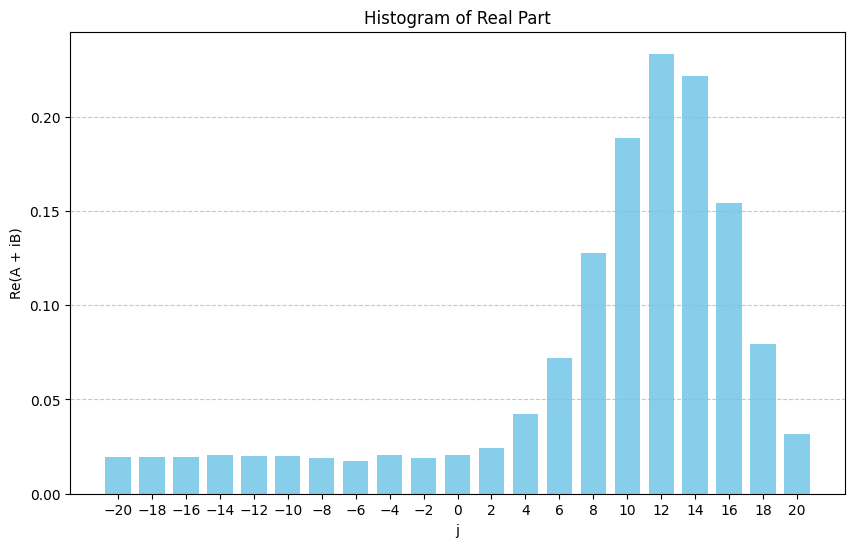

In [52]:
# get j, real
j_values = df_ft["j"].values
ft_real = np.real(df_ft["FT"].values)

# sort by j
sorted_indices = np.argsort(j_values)
j_sorted = j_values[sorted_indices].astype(int)
ft_sorted = ft_real[sorted_indices]

# plot
plt.figure(figsize=(10,6))
plt.bar(j_sorted, ft_sorted, width=1.5, color='skyblue')
plt.xlabel("j")
plt.ylabel("Re(A + iB)")
plt.title("Histogram of Real Part")
plt.xticks(j_sorted)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# put classic and quantum together

/Users/leonlee/.pyenv/versions/3.12.7/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/leonlee/.pyenv/versions/3.12.7/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


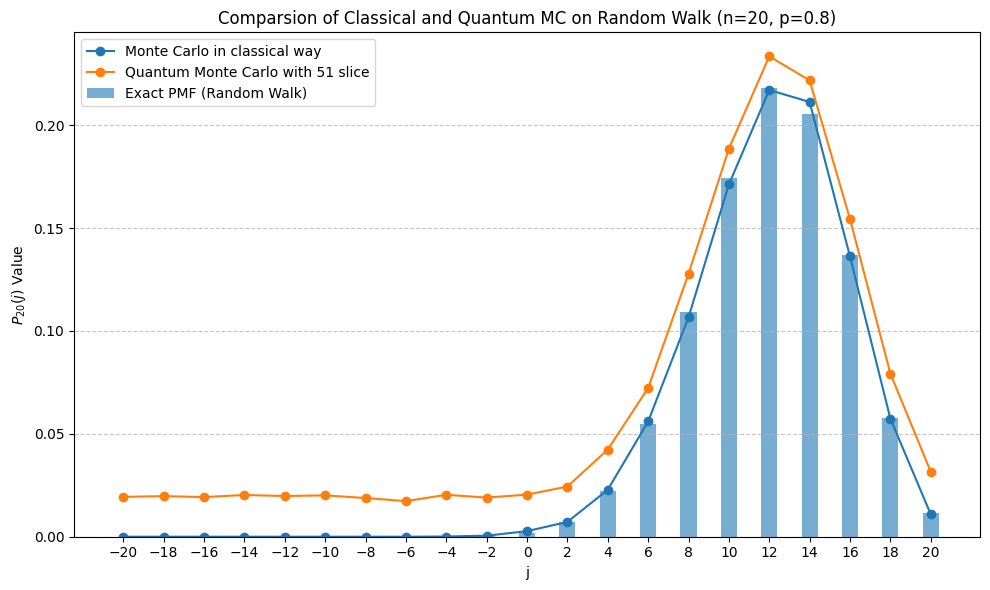

In [53]:

# -------------------- USER SETTINGS --------------------
p = 0.8        # Probability of moving right (+1) each step
n = 20         # Number of steps
RUN_SIM = True # Whether to run Monte Carlo verification
trials = 10000 # Number of Monte Carlo trials
# -------------------------------------------------------

def random_walk_pmf(n: int, p: float):
    """Exact distribution of 1D biased random walk (start at 0) after n steps."""
    if not (0 <= p <= 1):
        raise ValueError("p must be in [0, 1].")
    if n < 0 or int(n) != n:
        raise ValueError("n must be a non-negative integer.")

    js = np.arange(-n, n+1, 2)    # only positions with same parity as n
    k_right = (n + js) // 2       # number of +1 steps

    lgamma = math.lgamma
    if p == 0.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js == -n] = 1.0
        return js, pmf, k_right
    if p == 1.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js ==  n] = 1.0
        return js, pmf, k_right

    logC = np.array([lgamma(n+1) - lgamma(k+1) - lgamma(n-k+1) for k in k_right], dtype=float)
    logpmf = logC + k_right*np.log(p) + (n-k_right)*np.log(1-p)
    pmf = np.exp(logpmf)
    pmf = pmf / pmf.sum()  # normalize
    return js, pmf, k_right

def random_walk_monte_carlo(n: int, p: float, trials: int = 10000):
    """Monte Carlo empirical distribution for comparison."""
    steps = np.where(np.random.rand(trials, n) < p, 1, -1)
    positions = steps.sum(axis=1)
    counts = Counter(positions.tolist())
    js = np.arange(-n, n+1, 2)
    freq = np.array([counts.get(j, 0) for j in js], dtype=float) / trials
    return js, freq

# ==== step 1 : random walk distribution ====
js, pmf, _ = random_walk_pmf(n, p)

# ==== step 2 : df_ft histogram
j_values = df_ft["j"].values
ft_real = np.real(df_ft["FT"].values)
sorted_indices = np.argsort(j_values)
j_sorted = j_values[sorted_indices].astype(int)
ft_sorted = ft_real[sorted_indices]

# plot
plt.figure(figsize=(10,6))

# step 1: Exact PMF
plt.bar(js, pmf, width=0.8, alpha=0.6, label="Exact PMF (Random Walk)")

# if MC
if RUN_SIM:
    js_sim, freq = random_walk_monte_carlo(n, p, trials=trials)
    plt.plot(js_sim, freq, marker="o", linestyle="-", label=f"Monte Carlo in classical way")

# plot step 2
plt.plot(df_ft["j"], df_ft["FT"], marker='o', linestyle='-', label=f"Quantum Monte Carlo with 51 slice")
plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparsion of Classical and Quantum MC on Random Walk (n={n}, p={p})")
plt.xticks(sorted(set(j_sorted) | set(js)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# cut more slice

## put codes together

In [54]:
def random_walk_pmf(n: int, p: float):
    """Exact distribution of 1D biased random walk (start at 0) after n steps."""
    if not (0 <= p <= 1):
        raise ValueError("p must be in [0, 1].")
    if n < 0 or int(n) != n:
        raise ValueError("n must be a non-negative integer.")

    js = np.arange(-n, n+1, 2)    # only positions with same parity as n
    k_right = (n + js) // 2       # number of +1 steps

    lgamma = math.lgamma
    if p == 0.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js == -n] = 1.0
        return js, pmf, k_right
    if p == 1.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js ==  n] = 1.0
        return js, pmf, k_right

    logC = np.array([lgamma(n+1) - lgamma(k+1) - lgamma(n-k+1) for k in k_right], dtype=float)
    logpmf = logC + k_right*np.log(p) + (n-k_right)*np.log(1-p)
    pmf = np.exp(logpmf)
    pmf = pmf / pmf.sum()  # normalize
    return js, pmf, k_right


def random_walk_monte_carlo(n: int, p: float, trials: int = 10000):
    """Monte Carlo empirical distribution for comparison."""
    steps = np.where(np.random.rand(trials, n) < p, 1, -1)
    positions = steps.sum(axis=1)
    counts = Counter(positions.tolist())
    js = np.arange(-n, n+1, 2)
    freq = np.array([counts.get(j, 0) for j in js], dtype=float) / trials
    return js, freq

0.9272952180016123


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/4082564906.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "j_v": [ft_j]})], ignore_index=True)
/Users/leonlee/.pyenv/versions/3.12.7/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/leonlee/.pyenv/versions/3.12.7/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


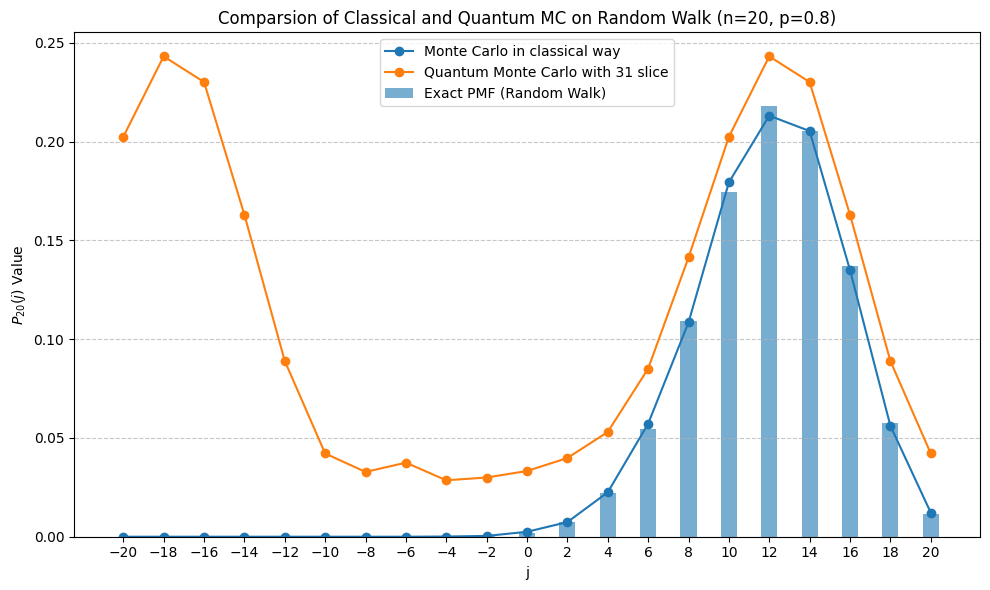

In [55]:
# phi
P = 0.8
phi = 2 * np.arccos(np.sqrt(P))
print(phi)

# settings
## slice
cut_slice = 31
## theta vals
theta_values = np.linspace(-np.pi, np.pi, cut_slice)
## step
step = 20

# A
results_list_A = []
for theta in theta_values:
    qr = QuantumRegister(step + 1, name='A')
    cr = ClassicalRegister(1, name='c_A')
    qc_A = QuantumCircuit(qr, cr)
    qc_A.ry(phi, range(step), r"$R_y(\phi)$")
    for ctrl_qubit in range(step):
        qc_A.x(ctrl_qubit)
        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_A.append(c_pos_gate, [ctrl_qubit, step])
        qc_A.x(ctrl_qubit)
        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_A.append(c_neg_gate, [ctrl_qubit, step])
        qc_A.barrier()
    qc_A.measure(step, 0)
    sampler = StatevectorSampler()
    result = sampler.run([(qc_A, None, 10000)]).result()
    data_pub = result[0].data
    counts = data_pub.c_A.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}
    one_value = frequencies.get('1', 0)
    results_list_A.append({
        "theta": theta,
        "freq_1": one_value
    })
df_A_v = pd.DataFrame(results_list_A)

# B
results_list_B = []
for theta in theta_values:
    qr = QuantumRegister(step + 1, name='B')
    cr = ClassicalRegister(1, name='c_B')
    qc_B = QuantumCircuit(qr, cr)
    qc_B.ry(phi, range(step), r"$R_y(\phi)$")
    qc_B.ry(-np.pi/2, step)
    for ctrl_qubit in range(step):
        qc_B.x(ctrl_qubit)
        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_B.append(c_pos_gate, [ctrl_qubit, step])
        qc_B.x(ctrl_qubit)
        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_B.append(c_neg_gate, [ctrl_qubit, step])
        qc_B.barrier()
    qc_B.measure(step, 0)
    sampler = StatevectorSampler()
    result = sampler.run([(qc_B, None, 10000)]).result()
    data_pub = result[0].data
    counts = data_pub.c_B.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}
    one_value = frequencies.get('1', 0)
    results_list_B.append({
        "theta": theta,
        "freq_1": one_value
    })
df_B_v = pd.DataFrame(results_list_B)

# adjust df
## df A
adj_df_A_v = df_A_v.copy()
adj_df_A_v["adj_freq"] = 1 - 2 * adj_df_A_v["freq_1"]
adj_df_A_v = adj_df_A_v.drop(columns=["freq_1"])
## df B
adj_df_B_v = df_B_v.copy()
adj_df_B_v["adj_freq"] = 1 - 2 * adj_df_B_v["freq_1"]
adj_df_B_v = adj_df_B_v.drop(columns=["freq_1"])
## combine adj df
df_A_sorted = adj_df_A_v.sort_values(by="theta").reset_index(drop=True)
df_B_sorted = adj_df_B_v.sort_values(by="theta").reset_index(drop=True)
complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]
df_complex = pd.DataFrame({
    "theta": df_A_sorted["theta"],
    "A_plus_iB": complex_values
})

# caculate p_nj
j_values = np.arange(-step, step+1, 2)
df_p_nj = pd.DataFrame(columns=["j", "j_v"])
for j in j_values:
    ft_j = np.sum(df_complex["A_plus_iB"] * np.exp(-1j * df_complex["theta"] * j)) / len(theta_values)
    df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "j_v": [ft_j]})], ignore_index=True)

# plot
## classical & real
p = 0.8
n = 20
trials = 10000
js, pmf, _ = random_walk_pmf(n, p)
j_values = df_ft["j"].values
ft_real = np.real(df_ft["FT"].values)
sorted_indices = np.argsort(j_values)
j_sorted = j_values[sorted_indices].astype(int)
ft_sorted = ft_real[sorted_indices]
plt.figure(figsize=(10,6))
plt.bar(js, pmf, width=0.8, alpha=0.6, label="Exact PMF (Random Walk)")
js_sim, freq = random_walk_monte_carlo(n, p, trials=trials)
plt.plot(js_sim, freq, marker="o", linestyle="-", label=f"Monte Carlo in classical way")
plt.plot(df_p_nj["j"], df_p_nj["j_v"], marker='o', linestyle='-', label=f"Quantum Monte Carlo with {cut_slice} slice")
plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparsion of Classical and Quantum MC on Random Walk (n={n}, p={p})")
plt.xticks(sorted(set(j_sorted) | set(js)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()




## for loop

### p = 0.8

0.9272952180016123
Running cut_slice = 51


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3252381890.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=51 完成，耗時 193.69 秒
Running cut_slice = 81


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3252381890.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=81 完成，耗時 312.89 秒
Running cut_slice = 111


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3252381890.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=111 完成，耗時 419.20 秒
Running cut_slice = 141


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3252381890.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=141 完成，耗時 531.05 秒
Running cut_slice = 171
cut_slice=171 完成，耗時 634.33 秒


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3252381890.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


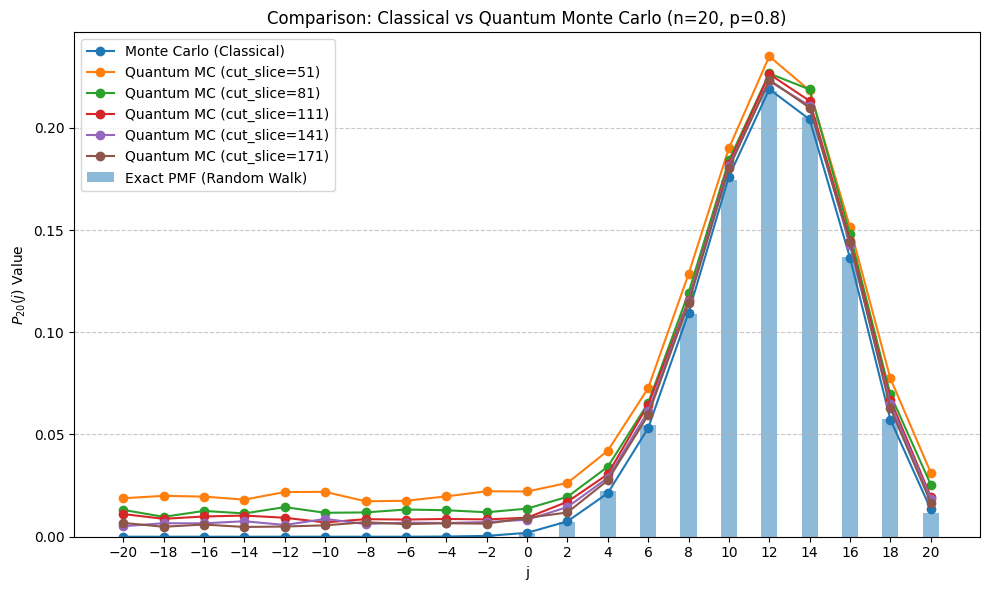

In [56]:
# phi
P = 0.8
phi = 2 * np.arccos(np.sqrt(P))
print(phi)
# step
step = 20
all_results = []

# run different cut_slice
for cut_slice in range(51, 172, 30):
    start_time = time.time()
    print(f"Running cut_slice = {cut_slice}")
    theta_values = np.linspace(-np.pi, np.pi, cut_slice)

    # A
    results_list_A = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='A')
        cr = ClassicalRegister(1, name='c_A')
        qc_A = QuantumCircuit(qr, cr)
        qc_A.ry(phi, range(step), r"$R_y(\phi)$")
        for ctrl_qubit in range(step):
            qc_A.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_A.append(c_pos_gate, [ctrl_qubit, step])
            qc_A.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_A.append(c_neg_gate, [ctrl_qubit, step])
            qc_A.barrier()
        qc_A.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_A, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_A.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_A.append({"theta": theta, "freq_1": one_value})
    df_A_v = pd.DataFrame(results_list_A)

    # B
    results_list_B = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='B')
        cr = ClassicalRegister(1, name='c_B')
        qc_B = QuantumCircuit(qr, cr)
        qc_B.ry(phi, range(step), r"$R_y(\phi)$")
        qc_B.ry(-np.pi/2, step)
        for ctrl_qubit in range(step):
            qc_B.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_B.append(c_pos_gate, [ctrl_qubit, step])
            qc_B.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_B.append(c_neg_gate, [ctrl_qubit, step])
            qc_B.barrier()
        qc_B.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_B, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_B.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_B.append({"theta": theta, "freq_1": one_value})
    df_B_v = pd.DataFrame(results_list_B)

    # adjust value
    adj_df_A_v = df_A_v.copy()
    adj_df_A_v["adj_freq"] = 1 - 2 * adj_df_A_v["freq_1"]
    adj_df_B_v = df_B_v.copy()
    adj_df_B_v["adj_freq"] = 1 - 2 * adj_df_B_v["freq_1"]
    df_A_sorted = adj_df_A_v.sort_values(by="theta").reset_index(drop=True)
    df_B_sorted = adj_df_B_v.sort_values(by="theta").reset_index(drop=True)
    complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]

    # Fourier Transform
    j_values = np.arange(-step, step+1, 2)
    df_p_nj = pd.DataFrame(columns=["j", "FT"])
    for j in j_values:
        ft_j = np.sum(complex_values * np.exp(-1j * df_A_sorted["theta"] * j)) / len(theta_values)
        df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)

    df_p_nj["cut_slice"] = cut_slice
    all_results.append(df_p_nj)

    # count time
    elapsed_time = time.time() - start_time
    print(f"cut_slice={cut_slice} 完成，耗時 {elapsed_time:.2f} 秒")

# combine
final_total_df = pd.concat(all_results, ignore_index=True)

# plot
p = 0.8
n = 20
trials = 10000
js_exact, pmf_exact, _ = random_walk_pmf(n, p)
js_sim, freq_sim = random_walk_monte_carlo(n, p, trials=trials)
plt.figure(figsize=(10, 6))
plt.bar(js_exact, pmf_exact, width=0.8, alpha=0.5, label="Exact PMF (Random Walk)")
plt.plot(js_sim, freq_sim, marker="o", linestyle="-", label="Monte Carlo (Classical)")
for cut_slice in final_total_df["cut_slice"].unique():
    sub_df = final_total_df[final_total_df["cut_slice"] == cut_slice]
    plt.plot(sub_df["j"], sub_df["FT"], marker='o', linestyle='-', label=f"Quantum MC (cut_slice={cut_slice})")
plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparison: Classical vs Quantum Monte Carlo (n={n}, p={p})")
plt.xticks(sorted(set(js_exact) | set(js_sim) | set(final_total_df["j"])))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


1.5707963267948966
Running cut_slice = 51


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3692645230.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=51 完成，耗時 185.97 秒
Running cut_slice = 81


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3692645230.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=81 完成，耗時 304.05 秒
Running cut_slice = 111


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3692645230.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=111 完成，耗時 413.43 秒
Running cut_slice = 141


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3692645230.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


cut_slice=141 完成，耗時 530.27 秒
Running cut_slice = 171
cut_slice=171 完成，耗時 641.31 秒


/var/folders/v_/1_ch33ds2bqgfv814hcng6tc0000gn/T/ipykernel_91704/3692645230.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)


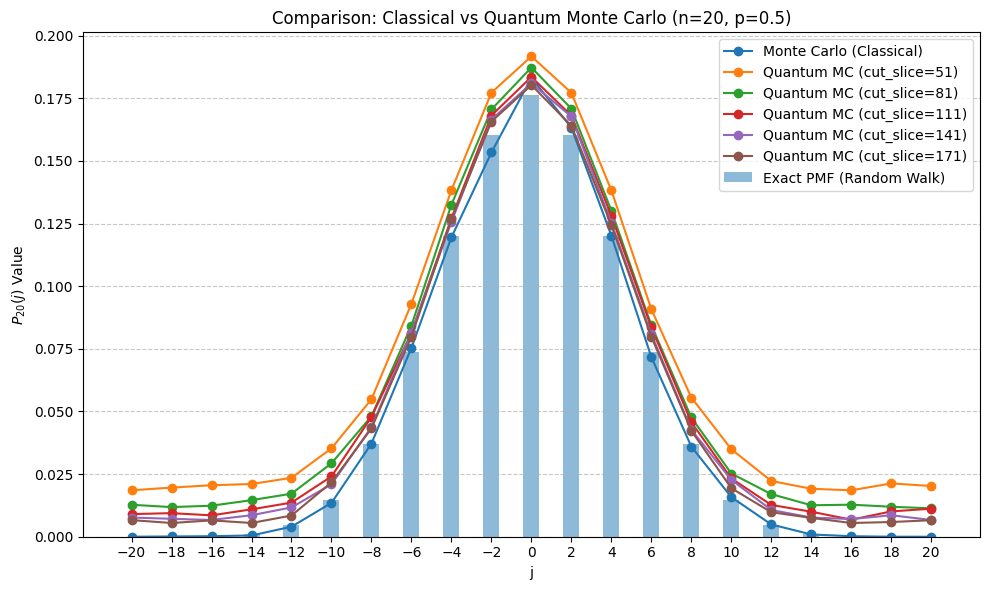

In [57]:
# phi
P = 0.5
phi = 2 * np.arccos(np.sqrt(P))
print(phi)
# step
step = 20
all_results = []

# run different cut_slice
for cut_slice in range(51, 172, 30):
    start_time = time.time()

    print(f"Running cut_slice = {cut_slice}")
    theta_values = np.linspace(-np.pi, np.pi, cut_slice)

    # A
    results_list_A = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='A')
        cr = ClassicalRegister(1, name='c_A')
        qc_A = QuantumCircuit(qr, cr)
        qc_A.ry(phi, range(step), r"$R_y(\phi)$")
        for ctrl_qubit in range(step):
            qc_A.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_A.append(c_pos_gate, [ctrl_qubit, step])
            qc_A.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_A.append(c_neg_gate, [ctrl_qubit, step])
            qc_A.barrier()
        qc_A.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_A, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_A.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_A.append({"theta": theta, "freq_1": one_value})
    df_A_v = pd.DataFrame(results_list_A)

    # B
    results_list_B = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='B')
        cr = ClassicalRegister(1, name='c_B')
        qc_B = QuantumCircuit(qr, cr)
        qc_B.ry(phi, range(step), r"$R_y(\phi)$")
        qc_B.ry(-np.pi/2, step)
        for ctrl_qubit in range(step):
            qc_B.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_B.append(c_pos_gate, [ctrl_qubit, step])
            qc_B.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_B.append(c_neg_gate, [ctrl_qubit, step])
            qc_B.barrier()
        qc_B.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_B, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_B.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_B.append({"theta": theta, "freq_1": one_value})
    df_B_v = pd.DataFrame(results_list_B)

    # adjust value
    adj_df_A_v = df_A_v.copy()
    adj_df_A_v["adj_freq"] = 1 - 2 * adj_df_A_v["freq_1"]
    adj_df_B_v = df_B_v.copy()
    adj_df_B_v["adj_freq"] = 1 - 2 * adj_df_B_v["freq_1"]
    df_A_sorted = adj_df_A_v.sort_values(by="theta").reset_index(drop=True)
    df_B_sorted = adj_df_B_v.sort_values(by="theta").reset_index(drop=True)
    complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]

    # Fourier Transform
    j_values = np.arange(-step, step+1, 2)
    df_p_nj = pd.DataFrame(columns=["j", "FT"])
    for j in j_values:
        ft_j = np.sum(complex_values * np.exp(-1j * df_A_sorted["theta"] * j)) / len(theta_values)
        df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)

    df_p_nj["cut_slice"] = cut_slice
    all_results.append(df_p_nj)

    elapsed_time = time.time() - start_time
    print(f"cut_slice={cut_slice} 完成，耗時 {elapsed_time:.2f} 秒")

# combine
final_total_df = pd.concat(all_results, ignore_index=True)

# plot
p = 0.5
n = 20
trials = 10000
js_exact, pmf_exact, _ = random_walk_pmf(n, p)
js_sim, freq_sim = random_walk_monte_carlo(n, p, trials=trials)
plt.figure(figsize=(10, 6))
plt.bar(js_exact, pmf_exact, width=0.8, alpha=0.5, label="Exact PMF (Random Walk)")
plt.plot(js_sim, freq_sim, marker="o", linestyle="-", label="Monte Carlo (Classical)")
for cut_slice in final_total_df["cut_slice"].unique():
    sub_df = final_total_df[final_total_df["cut_slice"] == cut_slice]
    plt.plot(sub_df["j"], sub_df["FT"], marker='o', linestyle='-', label=f"Quantum MC (cut_slice={cut_slice})")
plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparison: Classical vs Quantum Monte Carlo (n={n}, p={p})")
plt.xticks(sorted(set(js_exact) | set(js_sim) | set(final_total_df["j"])))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


$P_n(j) = \frac{1}{2 \pi} \int^{\pi}_{-\pi} (pe^{i\theta}+qe^{-i\theta})^{n} e^{-i \theta j} d \theta = \frac{1}{2 \pi} \underbrace{\sum^{\pi}_{\theta = -\pi}}_{M_i \text{ number of devision}} (pe^{i\theta}+qe^{-i\theta})^{\overbrace{n}^{\text{number of steps}}} e^{-i \theta j} \frac{2 \pi}{M}$